In [1]:
import numpy as np
from scipy.constants import c, e, m_p, epsilon_0, m_e
from joblib import Parallel, delayed
import sys

import PyHEADTAIL
import PyHEADTAIL.particles.generators as generators
from PyHEADTAIL.trackers.longitudinal_tracking import RFSystems, RFBucket
from PyHEADTAIL.impedances.wakes import WakeField, WakeSource, ResistiveWall
from PyHEADTAIL.particles import slicing
from tqdm.notebook import tqdm
from PyHEADTAIL.monitors.monitors import SliceMonitor
from matplotlib import pyplot as plt
from aps_figures.aps_one_column import *
from PyHEADTAIL.trackers.detuners import Chromaticity
from SOLEILII_parameters.SOLEILII_TDR_parameters import *
from PyHEADTAIL.radiation.radiation import SynchrotronRadiationTransverse, SynchrotronRadiationLongitudinal
np.random.seed(42)                            # Random seed (for particle distribution generation)
n_turns = 2049                                # Number of turns in the synchrotron
n_turns_slicemonitor = 2048                   # Number of turns to monitor motion withing the bunch
n_macroparticles = int(1e5)                   # Number of macroparticles in a single bunch
### 'Granularity' would be intensity/n_macroparticles
n_segments = 1                                # NUmber of segme nts for tranverse tracking
gamma = 1 + ENERGY * e / (m_e * c**2)
beta = np.sqrt(1 - gamma**-2)
PHI_RF = np.arcsin(U_LOSS/V_RF) if (GAMMA**-2-GAMMA_T**-2) < 0 else pi+np.arccos(U_LOSS/V_RF)
p_increment = -U_LOSS*e/c
print('Synchronous phase is {:.2f}'.format(PHI_RF))

PyHEADTAIL v1.14.1.67
(dirty git work tree)


Synchronous phase is 0.28


In [2]:
p0 = np.sqrt(gamma**2 - 1) * m_e * c
s = np.arange(0, n_segments + 1) * CIRCUMFERENCE / n_segments
alpha_x = ALPHA_X_SMOOTH * np.ones(n_segments)
beta_x = BETA_X_SMOOTH * np.ones(n_segments)
D_x = np.zeros(n_segments)
alpha_y = ALPHA_Y_SMOOTH * np.ones(n_segments)
beta_y = BETA_Y_SMOOTH * np.ones(n_segments)
D_y = np.zeros(n_segments)

In [3]:
long_map = RFSystems(CIRCUMFERENCE, [H_RF, ], [V_RF, ], [PHI_RF, ],
                     [ALPHA_0], gamma, p_increment = p_increment, mass=m_e, charge=e)
print(
    'Q_s: {0:.5f}'.format(
    long_map.Q_s))

Q_s: 0.00199


In order to achieve flat potential condition the following equations must me satisfied
\begin{equation}
\sin\phi_s = \frac{m^2}{m^2-1}\frac{U_s}{V_\text{rf}}
\end{equation}
\begin{equation}
\tan\phi_m = \frac{1}{m}\tan{\phi_s}
\end{equation}
\begin{equation}
r = \sqrt{\left( \frac{1}{m^2} - \frac{1}{m^2-1}\frac{U_s^2}{V^2_\text{rf}} \right)}
\end{equation}

In [4]:
# p_increment = U_LOSS*e/c
# m = 3
# PHI_RF = np.arcsin(m**2/(m**2-1)*U_LOSS/V_RF)
# PHI_M = np.arctan(1/m*np.tan(PHI_RF))
# r = np.sqrt(1/m**2-1/(m**2-1)*U_LOSS**2/V_RF**2)
# print('Voltage ration {:.3f}, synchronous phase {:.2f}, harmonic cavity phase {:.2f}'.format(r, PHI_RF, PHI_M))

In [5]:
bunch = generators.ParticleGenerator(macroparticlenumber=n_macroparticles, intensity=INTENSITY_PER_BUNCH, charge=e,
                                        gamma=gamma, mass=m_e, circumference=CIRCUMFERENCE,
                                        distribution_x=generators.gaussian2D(EPSILON_X),
                                        alpha_x=alpha_x, beta_x=beta_x,
                                        distribution_y=generators.gaussian2D(EPSILON_Y),
                                        alpha_y=alpha_y, beta_y=beta_y,
                                        limit_n_rms_x=3.5, limit_n_rms_y=3.5,
                                        distribution_z=generators.gaussian2D_asymmetrical(SIGMA_Z, SIGMA_DP),
                                         # distribution_z=generators.gaussian2D(emittance_z)
                                        ).generate()
print(SIGMA_Z, bunch.sigma_z())
print(SIGMA_DP, bunch.sigma_dp())
print(bunch.epsn_y()/bunch.betagamma)
print(EPSILON_Y)
print(bunch.p0)

0.0027 0.002702862875848173
0.0009 0.0009020344892662893
2.4935405581008347e-11
2.49e-11
1.469951715071603e-18


In [6]:
# rfb = RFBucket(CIRCUMFERENCE, gamma, m_e, e, [ALPHA_0], p_increment, [H_RF, m*H_RF], [V_RF, r*V_RF], [PHI_RF, PHI_M])
rfb = long_map.get_bucket(bunch)
dpmax = rfb.dp_max(rfb.z_ufp_separatrix)
# zz = np.linspace(2*rfb.z_left, 2*rfb.z_right, num=1000)
L_bucket = CIRCUMFERENCE/H_RF
zz = np.linspace(-L_bucket, L_bucket, num=5000)
ZZ, DP = np.meshgrid(zz, np.linspace(-dpmax*2, dpmax*2, num=5000))
hh = rfb.hamiltonian(ZZ, DP, make_convex=True)
bunch.z += rfb.z_sfp

[-0.07462433]


/tmp/ipykernel_13876/1906534485.py:5: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(ZZ, DP, hh, levels=levels, label=None, cmap=cmap)


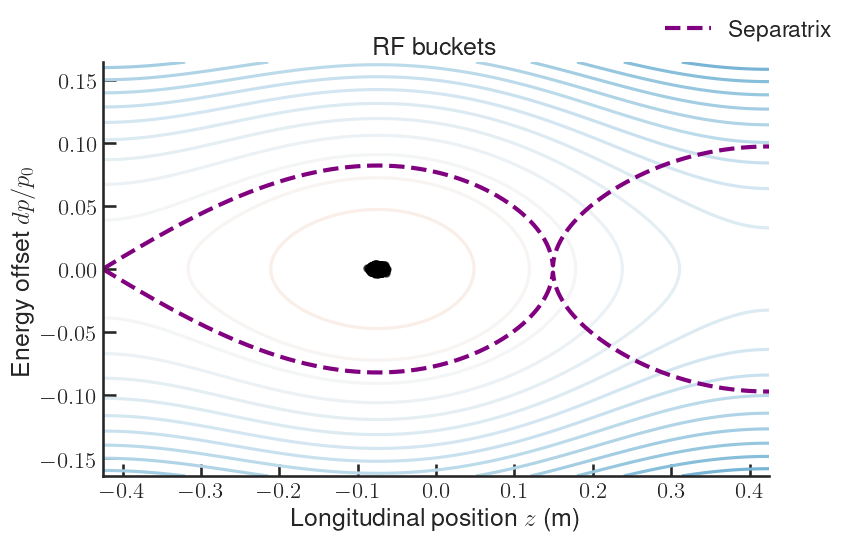

In [7]:
from matplotlib.cm import get_cmap
fig, ax = plt.subplots(1, 1)
levels = np.linspace(-1000, 1000, 50)
cmap = get_cmap('RdBu_r', levels.size)
ax.contour(ZZ, DP, hh, levels=levels, label=None, cmap=cmap)
ax.plot(zz, rfb.separatrix(zz), c='purple', lw=3, linestyle='dashed', label='Separatrix')
ax.plot(zz, -rfb.separatrix(zz), c='purple', lw=3, linestyle='dashed', label=None)
z0 = rfb.z_sfp # longitudinal position of the reference particle
print(z0)
# ax.scatter(z0, 0, label='Reference particle', marker='o', color='black')
ax.scatter(bunch.z, bunch.dp, marker='.', color='black', alpha=0.7)
ax.title.set_text('RF buckets')
ax.set_xlabel('Longitudinal position $z$ (m)')
ax.set_ylabel('Energy offset $dp/p_0$')
ax.set_xlim(-L_bucket/2, L_bucket/2)
plt.figlegend(frameon=False, loc='upper right')

In [8]:
n_wake_slices = 100                                     
z_cuts = (-4.2*bunch.sigma_z(), 4.2*bunch.sigma_z())    
print('Wake slicer range: ({0:.3f}, {1:.3f})'.format(z_cuts[0], z_cuts[1]))
wake_slicer = slicing.UniformBinSlicer(                            
    n_slices=n_wake_slices, z_cuts=z_cuts)
dt_min = SIGMA_Z/c/n_wake_slices                                 
res_wall = ResistiveWall(pipe_radius=2e-3,                      
                          resistive_wall_length=2*CIRCUMFERENCE,     
                          dt_min=dt_min,                           
                          Yokoya_X1=0,
                          Yokoya_X2 = 0,
                          Yokoya_Y2 = 0,
                          Yokoya_Y1=1,
                          conductivity=2.135e6 )          
wake_field = WakeField(wake_slicer, res_wall)
print(wake_field.wake_kicks[0])
print(res_wall.get_wake_kicks(wake_slicer)[0])

Wake slicer range: (-0.011, 0.011)


In [9]:
print('Transverse radiation damping times in turns {:.0f}, {:.0f}'.format(TAU_X*OMEGA_REV/(2*np.pi), TAU_Y*OMEGA_REV/(2*np.pi)))
print('Longitudinal radiation damping times in turns {:.0f}'.format(TAU_Z*OMEGA_REV/(2*np.pi)))
synchr_rad = SynchrotronRadiationTransverse(eq_emit_x = bunch.epsn_x(),
                                            eq_emit_y=bunch.epsn_y(),
                                            damping_time_x_turns=TAU_X*OMEGA_REV/(2*np.pi),
                                            damping_time_y_turns=TAU_Y*OMEGA_REV/(2*np.pi),
                                            beta_x=BETA_X_SMOOTH,
                                            beta_y=BETA_Y_SMOOTH)
synchr_rad_long = SynchrotronRadiationLongitudinal(eq_sig_dp=SIGMA_DP, damping_time_z_turns=TAU_Z*OMEGA_REV/(2*np.pi), E_loss_eV=e*U_LOSS )

Transverse radiation damping times in turns 6187, 11102
Longitudinal radiation damping times in turns 9916


In [10]:
from PyHEADTAIL.trackers.transverse_tracking import TransverseMap
chromaticity = 0
n_turns = 50000
slice_monitor = SliceMonitor(filename='htmonitor', n_steps=n_turns, slicer=wake_slicer, parameters_dict=None,
                 write_buffer_every=512, buffer_size=4096,)
chroma = Chromaticity(Qp_x=[1.6], Qp_y=[1.6])
trans_map = TransverseMap(s, alpha_x, beta_x, D_x,
                          alpha_y, beta_y, D_y, Q_X, Q_Y, [chroma])
trans_one_turn = [m for m in trans_map]
map_ = trans_one_turn + [long_map, wake_field]
for turn in tqdm(range(n_turns)):
    for m_ in map_:
        m_.track(bunch)
    slice_monitor.dump(bunch)

  0%|          | 0/50000 [00:00<?, ?it/s]

In [11]:
import h5py as hp
with hp.File('htmonitor.h5') as f:
    print(f.keys())
    print(f['Bunch'].keys())
    print(f['Slices'].keys())    
    mean_y = f['Bunch']['mean_y'][:]
    mean_x = f['Bunch']['mean_y'][:]
    mean_dp = f['Bunch']['mean_dp'][:]
    mean_z = f['Bunch']['mean_z'][:]
    sigma_y = f['Bunch']['sigma_y'][:]    

<KeysViewHDF5 ['Bunch', 'Slices']>
<KeysViewHDF5 ['epsn_x', 'epsn_y', 'epsn_z', 'macroparticlenumber', 'mean_dp', 'mean_x', 'mean_xp', 'mean_y', 'mean_yp', 'mean_z', 'sigma_dp', 'sigma_x', 'sigma_y', 'sigma_z']>
<KeysViewHDF5 ['epsn_x', 'epsn_y', 'epsn_z', 'mean_dp', 'mean_x', 'mean_xp', 'mean_y', 'mean_yp', 'mean_z', 'n_macroparticles_per_slice', 'sigma_dp', 'sigma_x', 'sigma_y', 'sigma_z']>


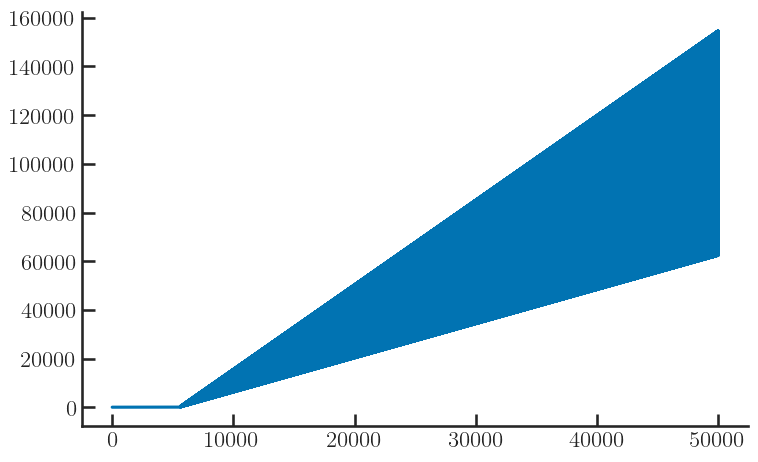

In [12]:
# plt.plot(mean_y/sigma_y[0])
# print(mean_y)
plt.plot(mean_dp)
# plt.plot(mean_y/sigma_y[0])
# plt.xlim(0, 1e5)
# plt.ylim(-1e2, 1e2)